In [ ]:
#to save a model i train
import joblib

# Saving the model to not retrain later
#joblib.dump(svm_1, "svm_1_v1.pkl")

# Load the model later
#loaded_model = joblib.load("svm_1_v1.pkl")

# Make predictions with the loaded model
#y_pred = loaded_model.predict(X1_test)


**FIRST: Importing The Dataset**

We plan to use the exact same training, testing and validation elements. so we will import them from the same exact csv files to ensure fair and accurate comparison between the models.

In [18]:
import pandas as pd

train_df = pd.read_csv("../split_dataset/train_split.csv")
test_df = pd.read_csv("../split_dataset/test_split.csv")
val_df = pd.read_csv("../split_dataset/val_split.csv")

# Quick checks
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
print("Validation shape:", val_df.shape)



Train shape: (126035, 4)
Test shape: (42012, 4)
Validation shape: (42012, 4)


**Support Vector Machines (SVM)** are a powerful supervised learning algorithm commonly used for classification tasks.

The main idea behinf SVM is to find a hyperplane that best seperates the classes in a high-dimensional feature space. This hyperplane will act as a decision boundary, and the algorithm selects the way that maximizes the *margin*, which is the distance between the hyperplane and the nearest points of each class. These points are called *support vectors*, and they are the most important data points since they "support" the position of the hyperplane, in other words, if these support vectors were changed or removed, the decision boundary would shift, while points farther away have little effect. -----

By focusing on the support vectors, SVM can generalize well to new, unseen data. This will be very benefitial to our project, which aims to detect phishing emails. 

we will try different preprocessing techniques on the datasets, as well as modify the paramaters of SVM in order to find the most suitable model for our project. 

the evaluation metrics of each model will be:
1. Accuracy
2. Precision
3. Recall
4. F1-score
5. confusion matrix

**Preprocessing Method #1: TF-IDF v1**

TF-IDF is one of the classic vectorization techniques when it comes to text. 
It is simple and fast, computationally cheaper, interpretable; as in you can see which words have the highest weight for a document.It can also reduce the impact of common words.
some cons to using TF-IDF: it ignores word order and context, which can heavily affect accuracy when it comes to predicting phishing/ spam emails. it can be sparse and high dimensional, for example, if we have 200k unique words, each email is a 200k dimensional sparse vector. which can be crazy to use for training, and storing in a databse.


`max_features` controls the vocabulary size, if it's too small it can lead to losing important information on some words, if it's too large we have the risk of overfitting and longer training time, with more memory consumption.
for `max_features`, a good balanced number is usually around 5k - 20k, therefore we will try to train using different numbers in this range. 

`stop_words` are common words like "the", "is", "of"...etc. They don't add much meaning in the classification process. having it can help with training accuracy by making the model focus on other, possibly more important words.
but there may be a risk where it can hurt the performance, therefore we will have a run not including it. 





**TF-IDF_v1**

For this run, we are using `stop_words = english` to remove the common mostly useless repetative words in the english language as explained before.
We are setting `max_features = 10000` for subject, since subjects usually tend to have less words than the body and we wish to only consider important words used in a phishing context. while for body we will take `max_features = 15000` as a start. 

*Notice: after we see the shape, it says 25000 columns, since we combined the subject and body vectors for this run.*

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

# --- TF-IDF Run #1  ---
vectorizer1_subject = TfidfVectorizer(
    max_features=10000,   
    stop_words="english"
)
vectorizer1_body = TfidfVectorizer(
    max_features=15000,  
    stop_words="english"
)

X1_train_subject = vectorizer1_subject.fit_transform(train_df["subject"].fillna(""))
X1_test_subject = vectorizer1_subject.transform(test_df["subject"].fillna(""))
X1_val_subject = vectorizer1_subject.transform(val_df["subject"].fillna(""))

X1_train_body = vectorizer1_body.fit_transform(train_df["body"].fillna(""))
X1_test_body = vectorizer1_body.transform(test_df["body"].fillna(""))
X1_val_body = vectorizer1_body.transform(val_df["body"].fillna(""))

# we combine subject and body vectors using hstack
X1_train = hstack([X1_train_subject, X1_train_body])
X1_test = hstack([X1_test_subject, X1_test_body])
X1_val = hstack([X1_val_subject, X1_val_body])


y1_train = train_df["isPhishing"]
y1_test = test_df["isPhishing"]
y1_val = val_df["isPhishing"]

print("Run 1 (TF-IDF separate subject+body) shapes:")
print("Train:", X1_train.shape, " Test:", X1_test.shape, " Val:", X1_val.shape)



Run 1 (TF-IDF separate subject+body) shapes:
Train: (126035, 25000)  Test: (42012, 25000)  Val: (42012, 25000)


**SVM: Linear Run#1 Using TF-IDF_v1**

For this run, we will use linear SVC since we have a big dataset (a little over 200k emails).
`C` is the regulation paramater, it basically controls the tradeoff between:
1. Maximizing the margin: having a simpler model that is more generalizable; which can mean a less accurate model, that can be more likely to misclassify emails. and risk of having an underfitted model, since it wil allow some error in training.
2. Minimizing misclassification on training data: fitting training points closely; which can increase the risk of overfitting. 

`max_iter` is the maximum number of itterations the SVM solver will run while trying to find the optimal hyperplane. each iteration updates the model weights a little bit; after enough itterations the algorith, converges to a solution.
LinearSVC uses an iretative optimization algorith (typically *coordinate descent*) to minimize the SVM objective function. if the algorithm doesn't converge before `max_iter` iterations, it stops and throws a <u>**convergence warning**</u>. 
*If we donot get that error no point of increasing or changing the value of `max_iter`*. 

`random_state` is an important paramater for reproducibility. it's a seed for a random number generartior used by the algorith. since many parts of ML training involves randomness, such as initialization of weights, shuffling data for optimization, tie-breaking in SVM solver, it is important to have it so the run ( even with identical dataset) will produce the same result. which is important for comparing, experimenting and debugging later. 

we will choose `random_state= 42` for now.

the produced model will be `svm_1_v1.pkl`.

--- Training Metrics ---
Accuracy: 0.997468957035744
Precision: 0.9966831414919295
Recall: 0.9980761641673244
F1-score: 0.9973791664270397

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     65219
           1       1.00      1.00      1.00     60816

    accuracy                           1.00    126035
   macro avg       1.00      1.00      1.00    126035
weighted avg       1.00      1.00      1.00    126035



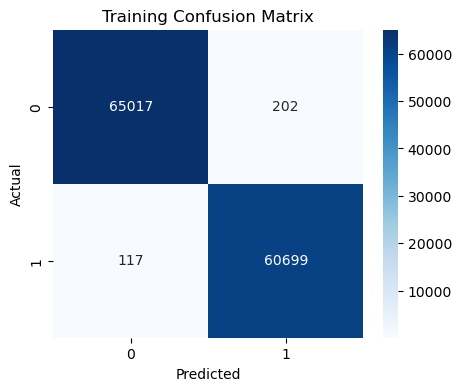

--- Test Metrics ---
Accuracy: 0.9812434542511663
Precision: 0.9777363672028246
Recall: 0.9835240726124704
F1-score: 0.9806216801101711

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98     21740
           1       0.98      0.98      0.98     20272

    accuracy                           0.98     42012
   macro avg       0.98      0.98      0.98     42012
weighted avg       0.98      0.98      0.98     42012



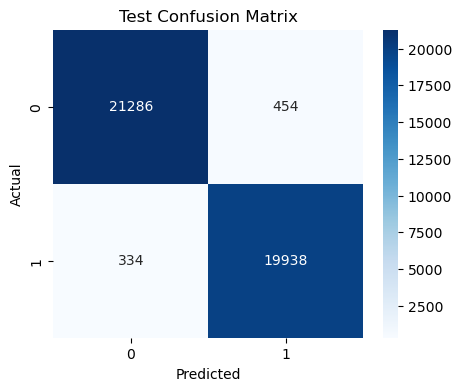

--- Validation Metrics ---
Accuracy: 0.982338379510616
Precision: 0.9801839012637066
Recall: 0.9832782518620826
F1-score: 0.9817286382664369

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98     21739
           1       0.98      0.98      0.98     20273

    accuracy                           0.98     42012
   macro avg       0.98      0.98      0.98     42012
weighted avg       0.98      0.98      0.98     42012



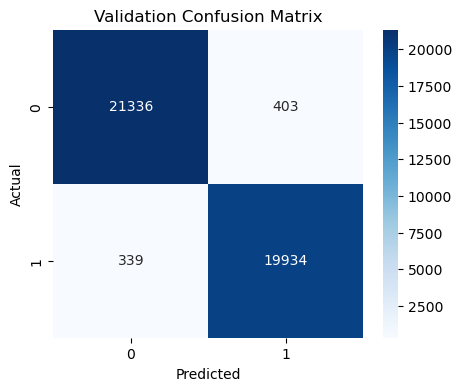

In [12]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


svm_1 = LinearSVC(
    C=1.0,  # Regularization parameter; 1.0 is default.
    max_iter=5000,   # you can increase to ensure convergence
    random_state=42
)


svm_1.fit(X1_train, y1_train)


y_train_pred = svm_1.predict(X1_train)
y_test_pred = svm_1.predict(X1_test)
y_val_pred = svm_1.predict(X1_val)

# --- Metrics function ---
def print_metrics(y_true, y_pred, dataset_name="Dataset"):
    print(f"--- {dataset_name} Metrics ---")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1-score:", f1_score(y_true, y_pred))
    print("\nClassification Report:\n", classification_report(y_true, y_pred))
    
    # Confusion matrix plot
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{dataset_name} Confusion Matrix")
    plt.show()

# --- Print metrics for all splits ---
print_metrics(y1_train, y_train_pred, "Training")
print_metrics(y1_test, y_test_pred, "Test")
print_metrics(y1_val, y_val_pred, "Validation")
#save model
joblib.dump(svm_1, "svm_1_v1.pkl") 

The SVM model `svm_1_v1` excellent performance across all splits.

On the training set, the model reached an accuracy of approximately 99.75% with an F1-score of 99.73%, indicating it learned the patterns in the training data very well. On the unseen test and validation sets, the model maintained strong performance, achieving accuracies of 98.12% and 98.23% and F1-scores of 98.06% and 98.17%, respectively.

The slight drop from training to test and validation indicates a <u>minor degree of overfitting</u>, which is expected given the **high-dimensional TF-IDF features**. 

Overall, the high precision and recall across all splits suggest that the model is highly effective at correctly identifying both phishing and non-phishing emails, with very few false positives or false negatives. The results demonstrate that the model generalizes well to new data, and any minor overfitting could be further mitigated by slightly <u>reducing the regularization parameter C</u> or <u>limiting the number of TF-IDF features</u>.



**SVM: Linear Run#2 Using TF-IDF_v1**

The goal is to try and reduce the overfitting found in *SVM: Linear Run#1 TF-IDF_v1* by manipulating the value of the paramater `C`.

in this run, i will try trducing the value of `C` to `0.8` as an attempt to reduce the overfitting caused in *SVM: Linear Run#1 TF-IDF#1*.


the produced model will be `svm_1_v2.pkl`.

--- Training Metrics ---
Accuracy: 0.9970087674058793
Precision: 0.9960440570575007
Recall: 0.997763746382531
F1-score: 0.9969031600910159

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     65219
           1       1.00      1.00      1.00     60816

    accuracy                           1.00    126035
   macro avg       1.00      1.00      1.00    126035
weighted avg       1.00      1.00      1.00    126035



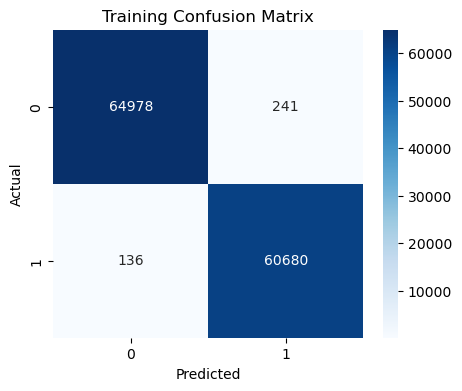

--- Test Metrics ---
Accuracy: 0.9814814814814815
Precision: 0.9779346866725508
Recall: 0.983820047355959
F1-score: 0.9808685388285053

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98     21740
           1       0.98      0.98      0.98     20272

    accuracy                           0.98     42012
   macro avg       0.98      0.98      0.98     42012
weighted avg       0.98      0.98      0.98     42012



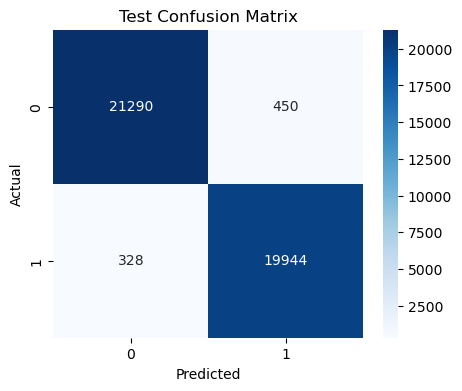

--- Validation Metrics ---
Accuracy: 0.9826954203560887
Precision: 0.9806235861119308
Recall: 0.9835742120061165
F1-score: 0.9820966828379344

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98     21739
           1       0.98      0.98      0.98     20273

    accuracy                           0.98     42012
   macro avg       0.98      0.98      0.98     42012
weighted avg       0.98      0.98      0.98     42012



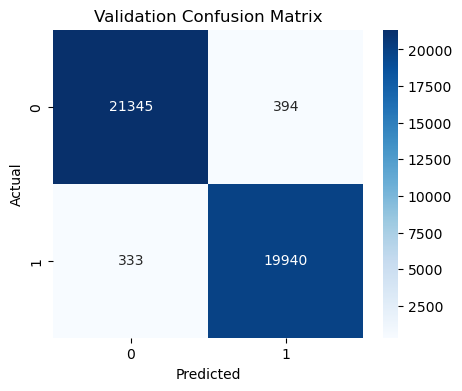

['svm_1_v2.pkl']

In [15]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


svm_1 = LinearSVC(
    C=0.8,  # Regularization parameter; 1.0 is default. 
    max_iter=5000,   # you can increase to ensure convergence
    random_state=42
)


svm_1.fit(X1_train, y1_train)


y_train_pred = svm_1.predict(X1_train)
y_test_pred = svm_1.predict(X1_test)
y_val_pred = svm_1.predict(X1_val)

# --- Metrics function ---
def print_metrics(y_true, y_pred, dataset_name="Dataset"):
    print(f"--- {dataset_name} Metrics ---")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1-score:", f1_score(y_true, y_pred))
    print("\nClassification Report:\n", classification_report(y_true, y_pred))
    
    # Confusion matrix plot
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{dataset_name} Confusion Matrix")
    plt.show()

# --- Print metrics for all splits ---
print_metrics(y1_train, y_train_pred, "Training")
print_metrics(y1_test, y_test_pred, "Test")
print_metrics(y1_val, y_val_pred, "Validation")
#save model
joblib.dump(svm_1, "svm_1_v2.pkl") 

We see very similar results to *SVM: Linear Run#1 Using TF-IDF_v1*. 

So the value of C was not enough to reduce the overfitting by much, although the model is less overfitted now. 

let's try `C = 0.5`. 

--- Training Metrics ---
Accuracy: 0.9954853810449479
Precision: 0.9944682457609034
Recall: 0.9961852144172586
F1-score: 0.99532598963339

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     65219
           1       0.99      1.00      1.00     60816

    accuracy                           1.00    126035
   macro avg       1.00      1.00      1.00    126035
weighted avg       1.00      1.00      1.00    126035



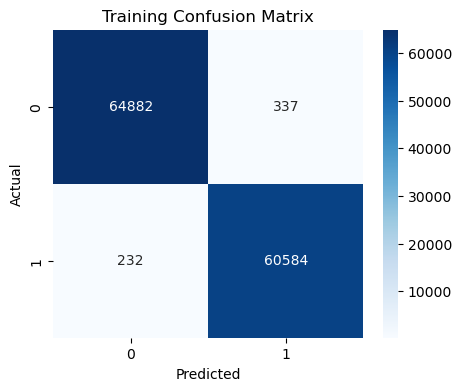

--- Test Metrics ---
Accuracy: 0.9819575359421118
Precision: 0.9782374277031664
Recall: 0.9845106550907656
F1-score: 0.981364016324925

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98     21740
           1       0.98      0.98      0.98     20272

    accuracy                           0.98     42012
   macro avg       0.98      0.98      0.98     42012
weighted avg       0.98      0.98      0.98     42012



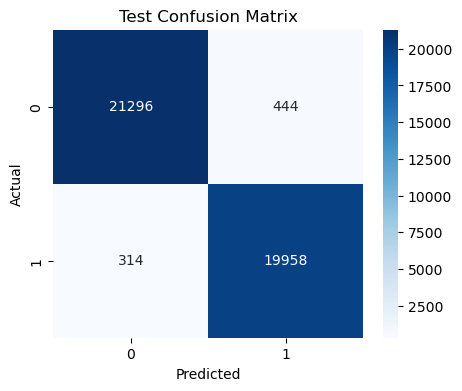

--- Validation Metrics ---
Accuracy: 0.9828620394173093
Precision: 0.9806302541664619
Recall: 0.9839194988408227
F1-score: 0.9822721229132811

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98     21739
           1       0.98      0.98      0.98     20273

    accuracy                           0.98     42012
   macro avg       0.98      0.98      0.98     42012
weighted avg       0.98      0.98      0.98     42012



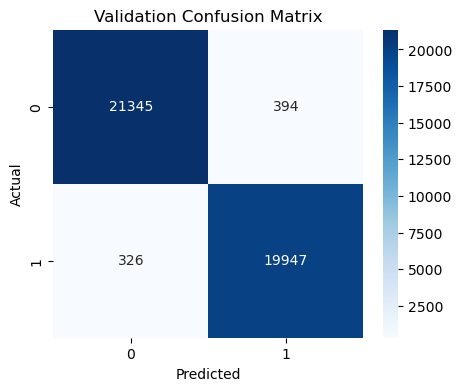

['svm_1_v2.pkl']

In [16]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


svm_1 = LinearSVC(
    C=0.5,  # Regularization parameter; 1.0 is default. 
    max_iter=5000,   # you can increase to ensure convergence
    random_state=42
)


svm_1.fit(X1_train, y1_train)


y_train_pred = svm_1.predict(X1_train)
y_test_pred = svm_1.predict(X1_test)
y_val_pred = svm_1.predict(X1_val)

# --- Metrics function ---
def print_metrics(y_true, y_pred, dataset_name="Dataset"):
    print(f"--- {dataset_name} Metrics ---")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1-score:", f1_score(y_true, y_pred))
    print("\nClassification Report:\n", classification_report(y_true, y_pred))
    
    # Confusion matrix plot
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{dataset_name} Confusion Matrix")
    plt.show()

# --- Print metrics for all splits ---
print_metrics(y1_train, y_train_pred, "Training")
print_metrics(y1_test, y_test_pred, "Test")
print_metrics(y1_val, y_val_pred, "Validation")
#save model
joblib.dump(svm_1, "svm_1_v2.pkl") 

The results are still very similar to the *SVM: Linear Run#1 Using TF-IDF_v1*. it seems like the model is less overfitted but not by a much.
It isn't wise to go less with C, we do not want to be underfitting. nontheless, we will try another run wth `C=0.1`. 

--- Training Metrics ---
Accuracy: 0.988582536596977
Precision: 0.986083140953223
Recall: 0.9903150486714023
F1-score: 0.9881945640848941

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     65219
           1       0.99      0.99      0.99     60816

    accuracy                           0.99    126035
   macro avg       0.99      0.99      0.99    126035
weighted avg       0.99      0.99      0.99    126035



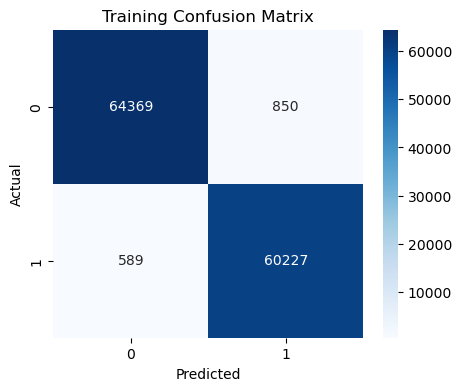

--- Test Metrics ---
Accuracy: 0.9802675426068742
Precision: 0.9761473282068864
Recall: 0.9831294396211523
F1-score: 0.9796259431295927

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98     21740
           1       0.98      0.98      0.98     20272

    accuracy                           0.98     42012
   macro avg       0.98      0.98      0.98     42012
weighted avg       0.98      0.98      0.98     42012



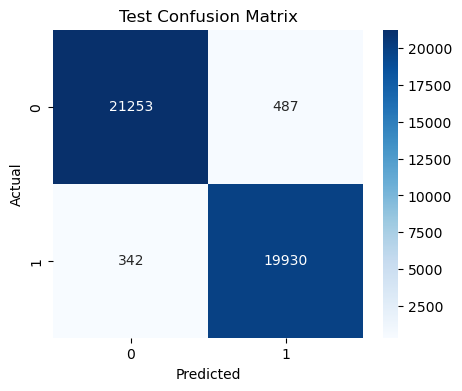

--- Validation Metrics ---
Accuracy: 0.9813148624202609
Precision: 0.978021978021978
Recall: 0.9833769052434272
F1-score: 0.9806921317362324

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98     21739
           1       0.98      0.98      0.98     20273

    accuracy                           0.98     42012
   macro avg       0.98      0.98      0.98     42012
weighted avg       0.98      0.98      0.98     42012



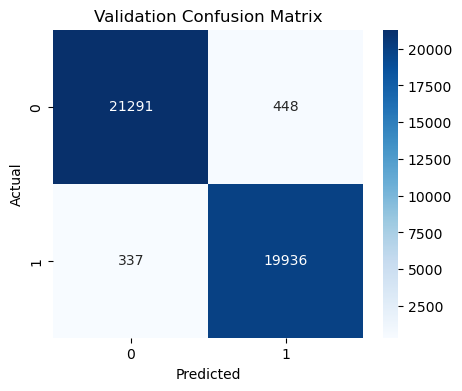

['svm_1_v2.pkl']

In [17]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


svm_1 = LinearSVC(
    C=0.1,  # Regularization parameter; 1.0 is default. 
    max_iter=5000,   # you can increase to ensure convergence
    random_state=42
)


svm_1.fit(X1_train, y1_train)


y_train_pred = svm_1.predict(X1_train)
y_test_pred = svm_1.predict(X1_test)
y_val_pred = svm_1.predict(X1_val)

# --- Metrics function ---
def print_metrics(y_true, y_pred, dataset_name="Dataset"):
    print(f"--- {dataset_name} Metrics ---")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1-score:", f1_score(y_true, y_pred))
    print("\nClassification Report:\n", classification_report(y_true, y_pred))
    
    # Confusion matrix plot
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{dataset_name} Confusion Matrix")
    plt.show()

# --- Print metrics for all splits ---
print_metrics(y1_train, y_train_pred, "Training")
print_metrics(y1_test, y_test_pred, "Test")
print_metrics(y1_val, y_val_pred, "Validation")
#save model
joblib.dump(svm_1, "svm_1_v2.pkl")

for the model trained with `C= 0.1`, we see that it has an accuracy of approximatly 98.86%, with an F1 score of 98.82%. On the test and validation sets, we see that the results have accuracies of 98.03% and 98.13% and F1-scores of 97.96% and 98.07%, respectively.

It seems that the new value of `C` managed to reduce overfitting, but at the cost of allowing the model to tollerate missclassification in the training data.

Still, the overall performance of the new model is still pretty good, it generalizes pretty well and produces high percision and recall across all splits.

The next logical step is to <u> modify some parmaters in the TF-IDF vectorization process</u>, and see if it will produce a more generalized model. 

**Preprocessing Method #1: TF-IDF v1**

**TO BE CONTINUED.......**